# NFインド株 (Nifty 50) ETF 日足

In [4]:
import sys
sys.path.append('..')

import re

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.technical import psar

In [5]:
pattern = re.compile(r'(.+)\.T')

symbol = '1678.T'
ticker = yf.Ticker(symbol)

df = ticker.history(period='6mo')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2024-09-05 00:00:00+09:00,363.600006,365.899994,362.299988,362.299988,1523950,0.0,0.0,0.0
2024-09-06 00:00:00+09:00,361.399994,361.799988,355.500000,356.000000,2332610,0.0,0.0,0.0
2024-09-09 00:00:00+09:00,350.100006,357.500000,349.500000,357.000000,2619550,0.0,0.0,0.0
2024-09-10 00:00:00+09:00,359.100006,360.299988,357.600006,359.000000,946060,0.0,0.0,0.0
2024-09-11 00:00:00+09:00,358.000000,358.299988,353.100006,354.700012,1270960,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2025-02-27 00:00:00+09:00,320.600006,321.700012,318.100006,319.200012,2545390,0.0,0.0,0.0
2025-02-28 00:00:00+09:00,318.500000,319.799988,315.000000,315.700012,2082540,0.0,0.0,0.0
2025-03-03 00:00:00+09:00,317.600006,319.799988,315.000000,315.000000,1932790,0.0,0.0,0.0


## 日足チャートとパラボリック SAR

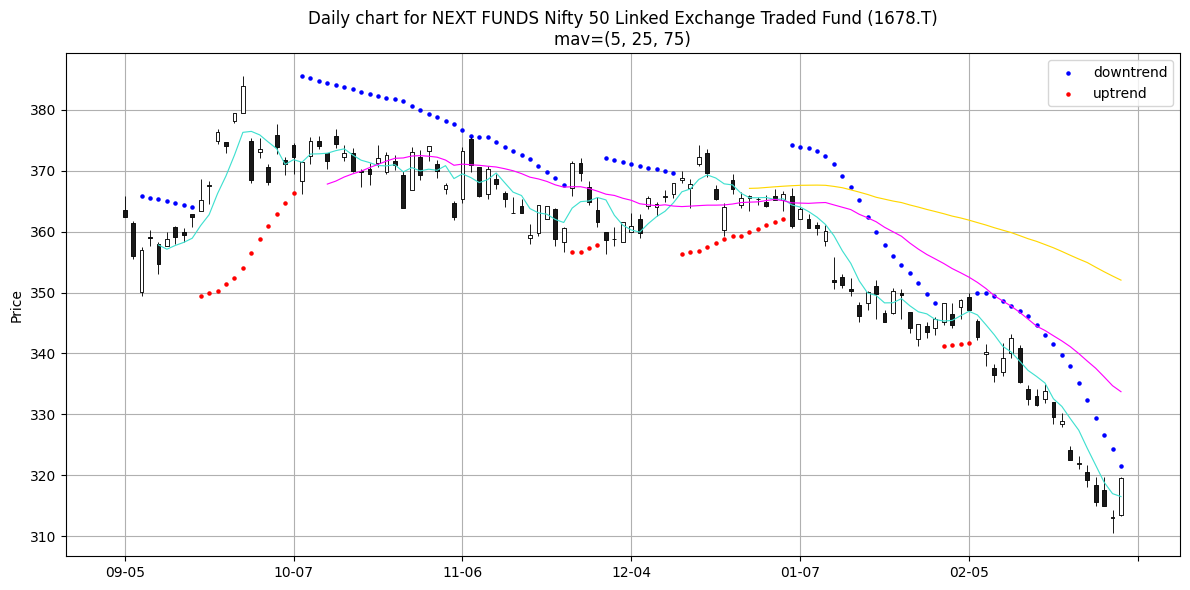

In [6]:
dict_psar = psar(df)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=5,
        color='blue',
        label='downtrend',
        ax=ax
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=5,
        color='red',
        label='uptrend',
        ax=ax
    ),
] 

mpf.plot(
    df,
    type='candle',
    style='default',
    mav=(5, 25, 75),
    volume=False,
    datetime_format='%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax,
)

try:
    ax.set_title('Daily chart for %s (%s)\nmav=(5, 25, 75)' % (ticker.info['longName'], symbol))
except KeyError:
    ax.set_title('Daily chart for %s\nmav=(5, 25, 75)' % symbol)

ax.grid()

plt.tight_layout()

m = pattern.match(symbol)
if m:
    plt.savefig('daily_chart_%s.png' % m.group(1))
else:
    plt.savefig('daily_chart_%s.png' % symbol)

plt.show()

In [12]:
df.tail(2)['Close']

Date
2025-02-21 00:00:00+09:00    329.000000
2025-02-25 00:00:00+09:00    322.899994
Name: Close, dtype: float64

In [13]:
df.tail(2)['Close'].diff()

Date
2025-02-21 00:00:00+09:00         NaN
2025-02-25 00:00:00+09:00   -6.100006
Name: Close, dtype: float64

In [14]:
df['Close'].rolling(5).mean().tail(2)

Date
2025-02-21 00:00:00+09:00    331.320001
2025-02-25 00:00:00+09:00    329.379999
Name: Close, dtype: float64

In [15]:
df['Close'].rolling(25).mean().tail(2)

Date
2025-02-21 00:00:00+09:00    342.060001
2025-02-25 00:00:00+09:00    341.128000
Name: Close, dtype: float64

In [16]:
df['Close'].rolling(75).mean().tail(2)

Date
2025-02-21 00:00:00+09:00    356.736
2025-02-25 00:00:00+09:00    356.108
Name: Close, dtype: float64